# Lab Two: Classification


*Contributors*: Balaji Avvaru, Joshua Eysenbach, Vijay Kaniti, Daniel Turner

## Data Preparation

### Data Preparation Part 1

As outlined in *Lab One: Visualization and Data Preprocessing*, this analysis uses a dataset built for categorizing patients as with or without a cardiovascular disease (CVD) diagnosis.  It originally contained a collection of 11 attributes that were gathered with the intention of trying to identify potential characteristics of individuals that correlate with heart disease. Both in *Lab One* and the *Minilab*, we made some adjustments to the original dataset that included cleaning up bad data, adding new variables like *BMI*, and changing the structure of some attributes like *cholesterol* and *glucose* to be one-hot encoded into multiple columns.

We have two target variables we will examine in this lab using the CVD dataset. 

   • **CVD Diagnosis (*cardio*)**: This is a classification problem where the goal of our models will be to predict a positive or negative CVD diagnosis for each observed patient. The attribute is encoded as an integer with a positive diagnosis indicated in the data with a "1" and a negative with a "0". This classification model is the main focus of our analysis.

   • **Systolic Blood Pressure (*ap_hi*)**: This is a continuous measurement in mmHg of the observed patient at the time of screening. This is a regression problem where the goal of our models will be to predict a value for *ap_hi* for each patient to see if other factors can contribute to high blood pressure. The attribute is represented in this dataset as an integer that ranges from (after adjustments in *Lab 1*) 60 to 215. This analysis is secondary to our main classfication analysis and is mainly for exploring if there is is a way to predict systolic blood pressure when a heart diesase diagnosis is already known, and if other factors could contribute to that predictiion.

<b>Summary of Data Preprocessing (Done in *Lab-1* and *mini-lab*)</b>

 - Since the ID field is simply the ordered numbering of all of the observations, it is not useful to us so we droped it from our data frame.
 
 
 - We also see that the scale of age in days is cumbersome, so we converted it to years. The age range of 29 to 65 with a mean of 53 years is a fairly narrow scope; the prevalence of CVD is likely low amoung individuals younger than 29 but we could be missing a large component of the effects of age on CVD without data on patients older than 65.
 
 
 - The records are checked to see if any are exact duplicates. There are 24 individuals with the same values for this relatively small list of attributes is entirely possible in a dataset of 70,000. All of the duplicates appear very near the average or medians for the different attributes, making the likelihood of the duplicates high and their legitimacy believable. For that reason, we included them in our cardio prediction 
 
 
 - For age, we see that the lone 29 year old subject is a statistical outlier but not an unreasonable possibilty, so we included them in our cardio prediction
 
 
 - We knew it is impossible to have a diastolic blood pressure that is higher than a systolic blood pressure, and because the minimums and maximums of ap_hi and ap_lo overlap. There are 64 observations where ap_lo is greater than ap_hi. Viewing the records where ap_lo > ap_hi, it appears we could assume that all of these were accidentally entered in reverse, and simply swap the values rather than delete these observations due to the mistakes.
 
 
 - For the height attribute, we assumed 250 cm giant is an anomaly and removed that observation from the data frame. The unreasonably short records could be from entry errors stemming from accidental unit confusion (we know these aren't just children because the min age is 29). For example, the minimum of 55 cm could have been an erroneous entry for 5ft 5 inches, but it would be near impossible for us discern when this is truly the case for every observation. We used the cutoff of 120 cm (approx 4 ft) for the lower end of heights. 
 
 
 - The same goes for the weights; the very low values are not realistic, but the max of 200 kg is still within the realm of possibility. We used 40 kg as a cutoff. These cutoffs are somewhat arbitrary, but designed with the desire to minimize both the the number of extreme values and number of records removed.
 
 
 - Created new feature BMI(Body mass index) which is a ratio of weight (in kilograms) and height (in meters squared). A BMI over 25 is considered overweight, and over 30 is obese.
 
 
 - Gender feature contains integer values of "1" and "2", it will be treated as a continuous variable. So we created a new variable is_male that will be a 0 for false and 1 for true if the subject is male, and then deleted the old gender feature.
 
 
 -  The cholesterol and gluc attributes are technically ordinal as they represent normal, high, and very high levels of each characteristic, but the effect of each on the target variable may not necessarily be a constant relationship through the ordinal levels so we transformed these attributes into multiple binary attributes (for example, if a "very high" level of cholesterol happened to have a positive relationship with cardio but a "high" level actually decreased the chance of a positive diagnosis compared to "normal", then leaving the variable as ordinal would make it a poor predictor). After the change, a normal level is represented by a zero for both cholesterol_2 and cholesterol_3, a 1 in cholesterol_2 is a high level, and a 1 in cholesterol_3 is a very high level. The same applies for the new gluc attributes and then deleted the old cholesterol and gluc attributes.

In *Lab One*, we assessed if there any methods that could reduce the dimensionality of our dataset, but there was not much that could be done as we are already working with a small number of attributes. We did normalize the continuous attributes using StandardScaler() in the *MiniLab* to scale them between 0 and 1 before running models. That normalization is shown below after importing the data.

As far as unimportant variables, we have done several analyses that show that some of the attributes in the dataset have little to no effect on the classification of *cardio*, but because we don't have a high number of variables and will be cross-validating our models, we don't think there is significant reason to leave any out of our final dataset before we begin model building. We also don't know yet if some of those less important variables may be useful in the regression of *ap_hi*.

#### Data Import

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from plot_metric.functions import BinaryClassification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

df_onehot = pd.read_csv("https://raw.githubusercontent.com/jteysen/MSDS-7331-Machine-Learning-I/master/Code/Lab2/CVD_2.csv")

This is the unscaled data after all of the other pre-processing steps outlined above.

In [2]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68523 entries, 0 to 68522
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   height         68523 non-null  int64  
 1   weight         68523 non-null  float64
 2   ap_hi          68523 non-null  int64  
 3   ap_lo          68523 non-null  int64  
 4   smoke          68523 non-null  int64  
 5   alco           68523 non-null  int64  
 6   active         68523 non-null  int64  
 7   cardio         68523 non-null  int64  
 8   age_years      68523 non-null  int64  
 9   BMI            68523 non-null  float64
 10  is_male        68523 non-null  int64  
 11  cholesterol_2  68523 non-null  int64  
 12  cholesterol_3  68523 non-null  int64  
 13  gluc_2         68523 non-null  int64  
 14  gluc_3         68523 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 7.8 MB


In [3]:
df_onehot.head()

,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_years,BMI,is_male,cholesterol_2,cholesterol_3,gluc_2,gluc_3
0,168,62.0,110,80,0,0,1,0,50,31.0,0,0,0,0,0
1,156,85.0,140,90,0,0,1,1,55,42.5,1,0,1,0,0
2,165,64.0,130,70,0,0,0,1,52,32.0,1,0,1,0,0
3,169,82.0,150,100,0,0,1,1,48,41.0,0,0,0,0,0
4,156,56.0,100,60,0,0,0,0,48,28.0,1,0,0,0,0


As in the *MiniLab*, we will assign our dependent variable for the classification problem, *cardio*, to the object *Y* and the rest of the variables as predictors in *X*. Then the data is normailzed using *StandardScaler*.

In [3]:
df_1 = df_onehot.copy()
# separate independent and dependent features
if 'cardio' in df_onehot:
    y = df_onehot['cardio'].values # get the target variable
    del df_onehot['cardio'] # get rid of the class label
    X = df_onehot.values # use everything else to predict
    
# Normalize the data
scl = StandardScaler()
scaled_X = scl.fit_transform(X)

To predict systolic blood pressure, we need to use a regression model. In *Lab One*, we used a heatmap to view the correlation between all of the attributes in our dataset, and now we want to specifically look at the variables correlated with *ap_hi* that will be useful for prediction. We can also take what we know from *Lab One* about the correlation of our predictors to get an idea for any collinearity issues that might be present after we select them.

We will include the *cardio* attribute as a predictor for this regression analysis of *ap_hi* as it could be useful to know if there should be concern for high blood pressure (and its potential detrimental effects aside from heart diease) if a prior diagnosis for heart disease is given.

One important consideration for model building to predict *ap_hi* is the inclusion of *ap_lo* (diastolic pressure). This is obviously the most correlated variable but it has no practical relevance in a model as systolic and diastolic blood pressure are always measured at the same time and there isn't much point to using one as a predictor of the other. We will run the model including *ap_lo* to get a baseline for what we could maximally expect to achieve and then run again without it.

In [4]:
#correlation of all variables with ap_hi
cor = df_1.corr()
cor = pd.DataFrame(cor['ap_hi'])
cor.columns = ['Correlation to ap_hi']
cor.sort_values(by=['Correlation to ap_hi'], ascending=False)

,Correlation to ap_hi
ap_hi,1.000000
ap_lo,0.730532
cardio,0.429982
weight,0.269239
BMI,0.246824
age_years,0.210324
cholesterol_3,0.154572
cholesterol_2,0.099066
gluc_2,0.075761
gluc_3,0.063887


We are unlikely to get improved results for anything more than the top 6 correlated variables in the chart above in a linear regression model, as anything below those showed no sign of significant linear relationships. From our analysis in *Lab One*, we can be confident about minimizing multicollinearity by choosing these variables as well, since most of the collinear independent variables like *height* and *weight* only have one of the pair in the top 6 chosen. BMI and weight might be a pair to keep an eye on.

We also create an object that has more of the variables (only the very lowest correlated variables of *height* and *active* are excluded). Since we are cross validating, we can try to use these in some of the models to see if any improvement, contrary to our belief based on the correlations, is possible. We wont use the additional variables on the basic MLR model.

All of the objects are then normalized using StandardScaler.

In [5]:
# ap_hi Regression: Create objects for dependent variable and predictors
#1st predictor Group: ap_lo included, short list of highest correlated variables
X_r1o = df_1[['ap_lo', 'cardio', 'weight', 'BMI', 'age_years', 'cholesterol_3']]
#2nd predictor Group: ap_lo excluded, short list of highest correlated variables
X_r2o = df_1[['cardio', 'weight', 'BMI', 'age_years', 'cholesterol_3']]
#3rd predictor Group: ap_lo excluded, added additional variables that are less correlated
X_r3o = df_1[['cardio', 'weight', 'BMI', 'age_years', 'cholesterol_3', 'cholesterol_2', 'gluc_2', 'gluc_3', 'smoke', 'alco','is_male']]
#Dependent Variable - ap_hi
Y_ro = df_1[['ap_hi']]

# Normalize the data
scl = StandardScaler()
X_r1 = scl.fit_transform(X_r1o)
X_r2 = scl.fit_transform(X_r2o)
X_r3 = scl.fit_transform(X_r3o)
Y_r = scl.fit_transform(Y_ro)

### Data Preparation Part 2

The final dataset includes 15 features and 68523 observations with *cardio* as target variable for task 1 and *ap_hi* as target variable for task 2. The only variable that was not in the original source dataset is *BMI*, which is calculated from the height and weight of the patient. Other than BMI, the cholesterol and glucose attributes have been split into multiple one-hot encoded variables. The info for the *df_onehot* dataframe below shows the entire final dataset before using standard scaler. Note that the data is not scaled until it is converted to separate objects that contain the independent objects and the target classes. The scaled data objects are used to build the models. The scaling does not affect the data types so the *df_1.info()* below is an accurate depiction.

In [6]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68523 entries, 0 to 68522
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   height         68523 non-null  int64  
 1   weight         68523 non-null  float64
 2   ap_hi          68523 non-null  int64  
 3   ap_lo          68523 non-null  int64  
 4   smoke          68523 non-null  int64  
 5   alco           68523 non-null  int64  
 6   active         68523 non-null  int64  
 7   cardio         68523 non-null  int64  
 8   age_years      68523 non-null  int64  
 9   BMI            68523 non-null  float64
 10  is_male        68523 non-null  int64  
 11  cholesterol_2  68523 non-null  int64  
 12  cholesterol_3  68523 non-null  int64  
 13  gluc_2         68523 non-null  int64  
 14  gluc_3         68523 non-null  int64  
dtypes: float64(2), int64(13)
memory usage: 7.8 MB


## Modeling and Evaluation

### Modeling and Evaluation 1

#### *Evaluation Metrics*

**Task 1 - Classify *cardio* (CVD diagnosis):** For our classification models we will initially track the accuracy, precision, and recall of each model as they are built. The precision for our classification models represents the ratio of the patients that the model correctly identifies as a positive diagnosis out of all the patients the model identifies as positive. The recall (also referred to as sensitivity - we used this term in Lab 1 and the Minilab), represents the ability of the model to correctly identify true positive diagnoses. The accuracy represents how well the model classifies correctly both positive and negative diagnoses. As outlined in *Lab One*, the effectiveness of a prediction model for classifying CVD patients could be measured by any of these depending on the implementation. 

For example, the intent of the model could be to identify individuals likely to be diagnosed with cardiovascular disease so they can be given an objective reason to make behavioral changes to reduce their chances of a future diagnosis. In this case, a higher recall would be more relevant than precision or accuracy because there would be few downsides to making false positive classifications. AUC (Area under the curve; Receiver Operating Characteristic) could also be an effective metric under this principle as it measures the ability of the model to predict a higher score for positive examples.

On the other hand, if something like high blood pressure or cholesterol was found to be a highly significant predictor and there was a decision to be made about prescribing a drug that could have side effects for the patient, accuracy or a more balanced precision and recall might be more important as false positives become more of a concern. For reasons like these, a few different prediction models might be warranted for different specific uses. For tuning model performance and comparing them, we will focus on accuracy. We will take a look at any tendencies for certain model types to attain higher recall when accuracy is maximized to make some assumptions about which may be better for further tuning toward that metric in the future if desired.

**Task 2 - Predict *ap_hi* (systolic blood pressure):** Minimizing root mean square error (RMSE) in combination with cross validation is a good metric for evaluating the effectiveness of a regression model for systolic blood pressure. RMSE is commonly used as a regression metric because larger errors are assigned larger weights as a result of the errors being squared. This means our metric will penalize models more for more extreme errors which is ideal in our case because smaller variations from the actual blood pressure measurement are not as impactful to us as extreme deviations.

### Modeling and Evaluation 2

#### *Training/Test Split Method*

We chose a stratified k-fold validation algorithm for the classification task of *cardio*. In stratified k-fold cross-validation, the original sample is randomly partitioned into k equal size subsamples in which each fold contains roughly the same proportions of class labels. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k-1 subsamples are used as training data. The cross-validation process is then repeated k times (the folds), with each of the k subsamples used exactly once as the validation data. The k results from the folds can then be averaged (or examined/combined as appropriate) to produce a single estimation. The advantage of this method is that all observations are used for both training and validation, and each observation is used for validation exactly once.

The typical standard of 10 folds will be adequate for this dataset. As we determined in our intial data exploration in *Lab 1*, our target class is almost perfectly balanced between positive and negative diagnoses and we have 68,523 observations so it is unlikely that any of the folds of a 10-fold cv set will be a drastic departure from a true representative portion of the whole dataset, but we still used the stratified method to ensure that the the classes remain balanced in each fold.

For the regression modeling of *ap_hi* we are using 10-fold cross-validation as well under the same presumptions, but without stratification as the target class is continous.

In [7]:
#Create Cross Validation Procedure for Classification task
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, random_state=1234, shuffle=True)

#Create Cross Validation Procedure for Regression task
from sklearn.model_selection import KFold
rcv = KFold(n_splits=10, random_state=1234, shuffle=True)

### Modeling and Evaluation 3

#### Classification Models - Predicting *cardio* (Cardiovascular Disease Diagnosis) - Initial Setup

The following functions perform cross validation using cross_validate() for classification estimators and returns accuracy, precision, recall for each model.

This also provides the code for plot the receiver operating characteristic curve, or ROC curve, which illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. The ROC curves will be shown in the Analysis section.

In [8]:
# Model Metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
import time

def displayModel_metrics(best_model, grid_model, features, target, cv):   
    start = time.time()
    cv_results = cross_validate(best_model, features, target, cv=cv, scoring=['accuracy','precision','recall'], n_jobs=-1)
    elapsed_time = (time.time() - start) 
    print ('Fold Scores:')
    print(' ')
    print(cv_results['test_accuracy'])
    print(' ')
    print('Best Accuracy   :  {:.3f}'.format(grid_model.best_score_))
    print('Mean Accuracy   : ', cv_results['test_accuracy'].mean())
    print('Mean Precision  : ', cv_results['test_precision'].mean())
    print('Mean Recall     : ', cv_results['test_recall'].mean())
    print('Mean Fit Time   : ', cv_results['fit_time'].mean())
    print('Mean Score Time : ', cv_results['score_time'].mean())
    print('CV Time         : ', elapsed_time)
    return
    

In [9]:

# ROC curve plot
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn import metrics as mt

def roc_curve_plot(model_fit, features, target):

    sns.set_palette("dark")

    yhat_score = model_fit.predict_proba(features)

    # Compute ROC curve for a subset of interesting classes
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in np.unique(target):
        fpr[i], tpr[i], _ = mt.roc_curve(y, yhat_score[:, i], pos_label=i)
        roc_auc[i] = mt.auc(fpr[i], tpr[i])

    for i in np.unique(target):
        plt.plot(fpr[i], tpr[i], label= ('class %d (area = %0.2f)' % (i, roc_auc[i])))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    plt.legend(loc="lower right")  
    plt.title('Receiver operating characteristic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

#### Predicting *cardio* (Cardiovascular Disease Diagnosis) - Model 1: KNN Classification

The k-nearest neighbors (KNN) algorithm is a simple, supervised machine learning algorithm. KNN algorithms use data and classify new data points based on similarity measures (e.g. distance function). Classification is done by a majority vote to its neighbors.

<u>GridSearch Parameters:</u>

Weights: which can be set to either ‘uniform’, where each neighbor within the boundary carries the same weight or ‘distance’ where closer points will be more heavily weighted toward the decision. Note that when weights = 'distance' the class with the highest number in the boundary may not “win the vote”

Leaf_size: The leaf size was adjusted, using: 10, 30, and 100 as the parameters. While there is an over-head penalty with using smaller leaves, accuracy may increase, so we will use it in our Grid Search.

Metric: which refers to how the distance of neighboring points is chosen from the unknown point. 3 options chosen were ‘minkowski’, ‘euclidean’ and 'manhattan'.

n_neighbors: Number of neighbors to use, should take on 1 through 30. It was determined that the optimal number of neighbors is below 17. Above 17, the accuracy plateaus and start to decrease.

algorithm: Algorithm used to compute the nearest neighbors. Possible values for this parameter are ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’

Initial analysis identified n_neighbors and weights parameters are most significant in creating the best model to predict cardio.

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# define parameters
weights_KNN = ['uniform','distance']
metric_KNN = ['minkowski','euclidean', 'manhattan']
n_neighbors_KNN = [5, 13,15,17]

# define grid search
param_grid_KNN = dict(weights=weights_KNN, metric=metric_KNN, n_neighbors=n_neighbors_KNN)

KNN = KNeighborsClassifier()

grid_search_KNN = GridSearchCV(estimator=KNN, param_grid=param_grid_KNN, n_jobs=-1, cv=cv, verbose=1, 
                               scoring='accuracy',error_score=0)


In [12]:
%%time
grid_result_KNN = grid_search_KNN.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_KNN.best_score_, grid_result_KNN.best_params_))
means = grid_result_KNN.cv_results_['mean_test_score']
stds = grid_result_KNN.cv_results_['std_test_score']
params = grid_result_KNN.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  8.3min finished


Best: 0.721495 using {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'uniform'}
0.695022 (0.004967) with: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}
0.686368 (0.006015) with: {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
0.716475 (0.005037) with: {'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'uniform'}
0.707149 (0.004836) with: {'metric': 'minkowski', 'n_neighbors': 13, 'weights': 'distance'}
0.719306 (0.003644) with: {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'uniform'}
0.709762 (0.004677) with: {'metric': 'minkowski', 'n_neighbors': 15, 'weights': 'distance'}
0.720678 (0.004489) with: {'metric': 'minkowski', 'n_neighbors': 17, 'weights': 'uniform'}
0.711498 (0.004111) with: {'metric': 'minkowski', 'n_neighbors': 17, 'weights': 'distance'}
0.695022 (0.004967) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.686368 (0.006015) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.7

In [13]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_KNN =grid_result_KNN.best_estimator_
best_Estimator_KNN

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [14]:
# Display model metrics
displayModel_metrics(best_Estimator_KNN, grid_result_KNN, scaled_X, y, cv)

Fold Scores:
 
[0.7202685  0.723041   0.72114402 0.73438412 0.71643316 0.72095738
 0.7237303  0.71263865 0.71847636 0.72387624]
 
Best Accuracy   :  0.721
Mean Accuracy   :  0.7214949729491535
Mean Precision  :  0.7323412203534695
Mean Recall     :  0.6889970501474926
Mean Fit Time   :  7.58094367980957
Mean Score Time :  15.473478651046753
CV Time         :  40.79362082481384


#### Predicting *cardio* (Cardiovascular Disease Diagnosis) - Model 2: Random Forest Classification 

Random forest is an ensemble tree-based learning algorithm where it combines more than one algorithms of same or different kind for classifying objects. The Random Forest Classifier is a set of decision trees from randomly selected subset of training set. It aggregates the votes from different decision trees to decide the final class of the test object.

<u>GridSearch Parameters:</u>

n_estimators = number of trees in the forest

max_depth = max number of levels in each decision tree

min_samples_split = min number of data points placed in a node before the node is split

min_samples_leaf = min number of data points allowed in a leaf node

bootstrap = method for sampling data points (with or without replacement)

In [15]:
from sklearn.ensemble import RandomForestClassifier

# define parameters       
bootstrap_RF = [True]
max_depth_RF = [5, 10, 15, 20]
min_samples_leaf_RF = [3, 4, 5]
min_samples_split_RF = [8, 10, 12]
random_state_RF = [1234]
n_estimators_RF =  [100, 200, 300]

# define grid search
param_grid_RF = dict(n_estimators=n_estimators_RF, max_depth=max_depth_RF, random_state=random_state_RF,
                    bootstrap=bootstrap_RF, min_samples_leaf=min_samples_leaf_RF,
                    min_samples_split=min_samples_split_RF)

RF = RandomForestClassifier()

grid_search_RF = GridSearchCV(estimator=RF, param_grid=param_grid_RF, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [16]:
%%time
grid_result_RF = grid_search_RF.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_RF.best_score_, grid_result_RF.best_params_))
means = grid_result_RF.cv_results_['mean_test_score']
stds = grid_result_RF.cv_results_['std_test_score']
params = grid_result_RF.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 21.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 46.9min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 72.9min finished


Best: 0.734191 using {'bootstrap': True, 'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300, 'random_state': 1234}
0.727610 (0.006378) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 100, 'random_state': 1234}
0.727581 (0.005969) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200, 'random_state': 1234}
0.727989 (0.006085) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300, 'random_state': 1234}
0.727683 (0.006385) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 100, 'random_state': 1234}
0.727683 (0.005952) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200, 'random_state': 1234}
0.727975 (0.006093) with: {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 3, 'min

In [17]:
# # The GridSearch algorithm determined the following optimal parameters
best_Estimator_RF =grid_result_RF.best_estimator_
Coef_weights_RF = grid_result_RF.best_estimator_.feature_importances_
best_Estimator_RF

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=1234,
                       verbose=0, warm_start=False)

In [18]:
# Display model metrics
displayModel_metrics(best_Estimator_RF, grid_result_RF, scaled_X, y, cv)

Fold Scores:
 
[0.73383919 0.73325551 0.73179629 0.74824869 0.72387624 0.73453006
 0.73920023 0.73073555 0.72942207 0.73701109]
 
Best Accuracy   :  0.734
Mean Accuracy   :  0.7341914931261436
Mean Precision  :  0.7552933963184697
Mean Recall     :  0.6846312684365782
Mean Fit Time   :  51.29167113304138
Mean Score Time :  1.2984477043151856
CV Time         :  96.93559217453003


#### Predicting *cardio* (Cardiovascular Disease Diagnosis) -  Model 3: Support Vector Machine (SVM)

A Support Vector Machine (SVM) is a discriminative classifier formally defined by a separating hyperplane. In other words, given labeled training data (supervised learning), the algorithm outputs an optimal hyperplane which categorizes new examples. 

<u>GridSearch Parameters:</u>

loss: The possible options are ‘hinge’, ‘log’, ‘modified_huber’, ‘squared_hinge’, ‘perceptron’, or a regression loss: ‘squared_loss’, ‘huber’, ‘epsilon_insensitive’, or ‘squared_epsilon_insensitive’

penalty: The penalty (aka regularization term), Defaults to ‘l2’ which is the standard regularizer for linear SVM models. ‘l1’ and ‘elasticnet’ might bring sparsity to the model

alpha: Constant that multiplies the regularization term, The higher the value, the stronger the regularization. Also used to compute the learning rate when set to learning_rate is set to ‘optimal’

class_weight: Weights associated with classes. If not given, all classes are supposed to have weight one. 

max_iter: The maximum number of passes over the training data (aka epochs).

In [19]:
#SVM_SGD 
from sklearn.linear_model import SGDClassifier

SVM = SGDClassifier()
# define parameters
loss_SVM = ['modified_huber', 'hinge']
penalty_SVM = ['l2']
alpha_SVM = [0.01, 0.1, 1, 5, 10]
class_weight_SVM = ['balanced', None]
max_iter_SVM = [500, 1000, 1500]
random_state_SVM = [1234]

# define grid search
param_grid_SVM = dict(loss=loss_SVM, penalty=penalty_SVM, alpha=alpha_SVM,
                     class_weight=class_weight_SVM, max_iter=max_iter_SVM, random_state=random_state_SVM)

grid_search_SVM = GridSearchCV(estimator=SVM, param_grid=param_grid_SVM, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [20]:
%%time
grid_result_SVM = grid_search_SVM.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_SVM.best_score_, grid_result_SVM.best_params_))
means = grid_result_SVM.cv_results_['mean_test_score']
stds = grid_result_SVM.cv_results_['std_test_score']
params = grid_result_SVM.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   21.9s finished


Best: 0.727800 using {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 500, 'penalty': 'l2', 'random_state': 1234}
0.727800 (0.005374) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 500, 'penalty': 'l2', 'random_state': 1234}
0.727800 (0.005374) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 1234}
0.727800 (0.005374) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'modified_huber', 'max_iter': 1500, 'penalty': 'l2', 'random_state': 1234}
0.726749 (0.005953) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 500, 'penalty': 'l2', 'random_state': 1234}
0.726749 (0.005953) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'random_state': 1234}
0.726749 (0.005953) with: {'alpha': 0.01, 'class_weight': 'balanced', 'loss': 'hinge', 'max_iter': 1500, 'pe

In [21]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_SVM =grid_result_SVM.best_estimator_
best_Estimator_SVM

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='modified_huber',
              max_iter=500, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [22]:
# Display model metrics
displayModel_metrics(best_Estimator_SVM, grid_result_SVM, scaled_X, y, cv)

Fold Scores:
 
[0.7223114  0.73004524 0.72420838 0.73686515 0.71906013 0.7278167
 0.73175715 0.72212493 0.73131932 0.73248687]
 
Best Accuracy   :  0.728
Mean Accuracy   :  0.7277995247371859
Mean Precision  :  0.7539714879775031
Mean Recall     :  0.6679646017699115
Mean Fit Time   :  0.34886016845703127
Mean Score Time :  0.01977970600128174
CV Time         :  0.7780117988586426


#### Predicting *ap_hi* (Systolic Blood Pressure): Multiple Linear Regression

The second task is to use regression models to predict *ap_hi*. The very few linearly correlated variables aside from *ap_lo* indicate that the MLR model is unlikely to provide very good results, but we can (much like with temporary the inclusion of *ap_lo* in the basic linear model) get a baseline to see if random forest or other models are actually a worthwhile improvement.

We will attempt 3 model types in this analysis for regression; a multiple linear regression model, a random forest regression model, and a support vector regression model. It is also worth noting that the scikit learn package is lacking in linear regression situations in that is does not provide diagnositics and p-values for the coefficients of variables included in the model. *Statsmodels* is a package that provides more detail and options for linear regression, but does not provide any straight-forward method to apply the cross-validation we wish to consistently apply to all of our models in Lab 2. Since coefficients can be used to determine variable importance when data is scaled to values between zero and 1, we will be able to see which variables have little to no effect on the regression formula, but we won't know for sure if they are statistically significant based on p-values.

The code below runs a regression model to predict *ap_hi* with *ap_lo* included. The root mean squared error is used to score the validation runs and ultimately the model predictions. The average RMSE of the 10 folds of each parameter group is shown in the results. We also show the standard deviation of the the RMSE in the 10 folds so that we can see if the folds are returning consistent RMSE results (the average RMSE is a good representation of what we should get with those parameters with any subset or new data)  or if there is a lot of variation between them (this could mean we need to modify the cross validation technique or make some assumptions about minimum training set sizes).

In [11]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Regression Model
mlr = linear_model.LinearRegression().fit(X_r1, Y_r)

# score the regression model based on Root Mean Squared Error
mlr_preds = cross_val_predict(mlr, X_r1, Y_r, cv=rcv)
mlr_scores = cross_val_score(mlr, X_r1, Y_r, scoring='neg_root_mean_squared_error', cv=rcv)
print('Average of RMSE for 10 folds: ', np.mean(mlr_scores))
print('Standard Deviation of RMSE for 10 folds: ', np.std(mlr_scores))

Average of RMSE for 10 folds:  -0.6484302482313026
Standard Deviation of RMSE for 10 folds:  0.011415441738078732


The RMSE above represents the what we can get from a linear model using the *ap_lo* variable (or essentially all of the available data). Since we don't think including it is practical, we want to run the model without it, but we expect to see a worse RMSE as the remaining variables are not nearly as correlated.

We'll check the residuals of the first model predictions to make sure they appear as a random cloud without any significant outliers. If there were anny issues, we would want to sort that out now before running again. The plot below shows that the residuals are fairly normally distributed such that the assumption is not clearly violated.

<Figure size 864x576 with 0 Axes>

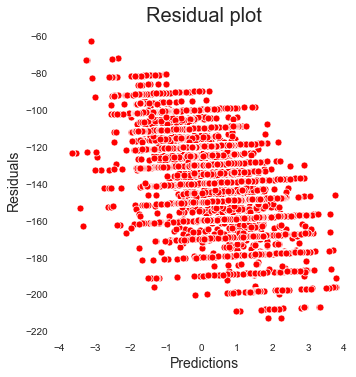

In [24]:
import seaborn as sns

rezdf = df_1
rezdf['preds'] = mlr_preds
rezdf['resids'] = (rezdf['preds'] - rezdf['ap_hi'])

# residual plot
fig = plt.figure(figsize = (12, 8))
sns.relplot(x='preds', y='resids', data=rezdf, color='red')
plt.title('Residual plot', size=20)
plt.xlabel('Predictions', size=14)
plt.ylabel('Residuals', size=14);

The code below runs the linear regression model with *ap_lo* excluded. This is what we are mainly interested in for comparison to the random forest model. Note that these sklearn functions use a *negative* root mean squared error, which for clarity would mean that when we make any reference to "lowering" or "minimizing" RMSE, we really mean getting it close to zero, not decreasing it further negative.

In [12]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Regression Model
mlr2 = linear_model.LinearRegression().fit(X_r2, Y_r)
# score the regression model based on Root Mean Squared Error
mlr2_preds = cross_val_predict(mlr, X_r2, Y_r, cv=rcv)
mlr2_scores = cross_val_score(mlr, X_r2, Y_r, scoring='neg_root_mean_squared_error', cv=rcv)

print('Average of RMSE for 10 folds (ap_lo excluded): ', np.mean(mlr2_scores))
print('Standard Deviation of RMSE for 10 folds(ap_lo excluded): ', np.std(mlr2_scores))

Average of RMSE for 10 folds (ap_lo excluded):  -0.8733669500799157
Standard Deviation of RMSE for 10 folds(ap_lo excluded):  0.0057606836423837095


The model performs notably worse without ap_lo, as expected, but the RMSE above is what we will use to compare to other model types.

The code below shows us the intercept and variable coefficients for the linear regression model. If we were invested in using an MLR model we would want to check the p-values of the coefficents to determine if they are significant predictors. But we are mainly interested in getting a baseline to see how much we can reduce the RMSE by using a random forest model and unfortunately Scikit Learn does not provide an easy way to obtain the p-values.

In [13]:
# intercept and regression model coefficients
coef2 = mlr2.coef_[0].tolist()
coefdf2 = pd.DataFrame(X_r2o.columns, columns=['Variable'])
coefdf2['Coefficient'] = coef2

print('Intercept: \n', mlr2.intercept_)
coefdf2

Intercept: 
 [1.64776545e-16]


,Variable,Coefficient
0,cardio,0.360426
1,weight,0.155151
2,BMI,0.046323
3,age_years,0.104975
4,cholesterol_3,0.046167


Since the data has been normalized, we can use the coefficients above to tell us which varaibles are the most important in the linear model by those with the highest coefficients.

Again we check the residuals of the model predictions to make sure they appear as a random cloud without any significant outliers. The plot below shows that the residuals are fairly normally distributed such that the assumption is not clearly violated.

<Figure size 864x576 with 0 Axes>

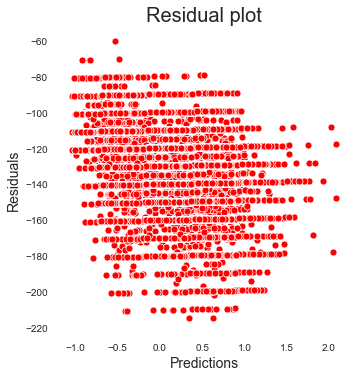

In [27]:
rezdf2 = df_1
rezdf2['preds'] = mlr2_preds
rezdf2['resids'] = (rezdf2['preds'] - rezdf2['ap_hi'])

# residual plot
fig = plt.figure(figsize = (12, 8))
sns.relplot(x='preds', y='resids', data=rezdf2, color='red')
plt.title('Residual plot', size=20)
plt.xlabel('Predictions', size=14)
plt.ylabel('Residuals', size=14);

Finally, we try the MLR model one more time using X_r3, which has almost all of the variables. This would be a situation where we are particularly in danger of overfitting, as some of these have very low correlation to the target attribute and some colinearity with other variables.

In [14]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# Regression Model
mlr3 = linear_model.LinearRegression().fit(X_r3, Y_r)
# score the regression model based on Root Mean Squared Error
mlr3_preds = cross_val_predict(mlr, X_r3, Y_r, cv=rcv)
mlr3_scores = cross_val_score(mlr, X_r3, Y_r, scoring='neg_root_mean_squared_error', cv=rcv)
MLR_score = np.mean(mlr3_scores)

print('Average of RMSE for 10 folds (ap_lo excluded): ', np.mean(mlr3_scores))
print('Standard Deviation of RMSE for 10 folds(ap_lo excluded): ', np.std(mlr3_scores))

Average of RMSE for 10 folds (ap_lo excluded):  -0.8699883525840914
Standard Deviation of RMSE for 10 folds(ap_lo excluded):  0.005895169592158192


The addition of more variables improved the RMSE slightly of the MLR model. Given the size of our dataset, it is still possible that we could be experiencing overfitting with 10 fold cross validation. The 10 folds still have a high enough number of observations that increasing the number of k folds might show that including all of these variables does in fact overfit the data, which could be examined at a later time if desired.

One last residual check:

<Figure size 864x576 with 0 Axes>

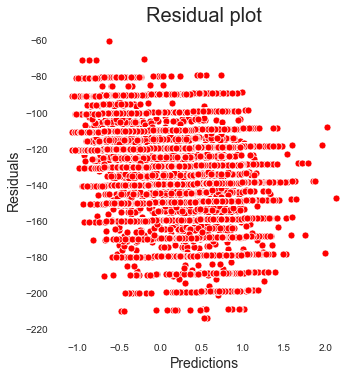

In [29]:
rezdf3 = df_1
rezdf3['preds'] = mlr3_preds
rezdf3['resids'] = (rezdf3['preds'] - rezdf3['ap_hi'])

# residual plot
fig = plt.figure(figsize = (12, 8))
sns.relplot(x='preds', y='resids', data=rezdf3, color='red')
plt.title('Residual plot', size=20)
plt.xlabel('Predictions', size=14)
plt.ylabel('Residuals', size=14);

The model coefficients for the expanded MLR model are shown below.

In [15]:
# intercept and regression model coefficients
coef3 = mlr3.coef_[0].tolist()
coefdf3 = pd.DataFrame(X_r3o.columns, columns=['Variable'])
coefdf3['Coefficient'] = coef3

print('Intercept: \n', mlr.intercept_)
coefdf3

Intercept: 
 [2.23788845e-16]


,Variable,Coefficient
0,cardio,0.354530
1,weight,0.140133
2,BMI,0.048980
3,age_years,0.105237
4,cholesterol_3,0.061597
5,cholesterol_2,0.057794
6,gluc_2,0.020814
7,gluc_3,-0.007700
8,smoke,0.008547
9,alco,0.016576


We can quickly see that the additional variables had very small effects based on their coefficients, but since the MLR model runs so fast, even with cross validation, there may not be a problem with including them. However, the cross validation method should probably be examined further to tell if there is still overfitting present. We will use this model to comapare to the Random Forest and SVR model results.

#### Predict *ap_hi* (Systolic Blood Pressure): Random Forest Regression

The code below formulates the Grid search for the best parameters for a Random Forest Regression model specifying the *max_depth* and *n_estimators* of the model. We'll take the model with the lowest mean RMSE of the cross-validated runs as the best. We will first use the same highest correlated variables from the linear regression analysis (excluding *ap_lo*).

<u>GridSearch Parameters:</u>

n_estimators = number of trees in the forest

max_depth = max number of levels in each decision tree

In [16]:
#from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#Random Forest Regression
rfr = RandomForestRegressor()

# define models and parameters
max_depth_rfr = [2,5,10,50,100] 
n_estimators_rfr = [10, 100, 1000]  

# define grid search
grid = dict(max_depth=max_depth_rfr, n_estimators=n_estimators_rfr)
grid_search = GridSearchCV(estimator=rfr, param_grid=grid, n_jobs=-1, cv=rcv, scoring='neg_root_mean_squared_error')

In [17]:
%%time
grid_result_rfr = grid_search.fit(X_r2, Y_r)
# summarize results
print("Best: %f using %s" % (grid_result_rfr.best_score_, grid_result_rfr.best_params_))
means = grid_result_rfr.cv_results_['mean_test_score']
stds = grid_result_rfr.cv_results_['std_test_score']
params = grid_result_rfr.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.871152 using {'max_depth': 5, 'n_estimators': 1000}
-0.885298 (0.006037) with: {'max_depth': 2, 'n_estimators': 10}
-0.885089 (0.006083) with: {'max_depth': 2, 'n_estimators': 100}
-0.885061 (0.006177) with: {'max_depth': 2, 'n_estimators': 1000}
-0.871734 (0.006783) with: {'max_depth': 5, 'n_estimators': 10}
-0.871168 (0.006585) with: {'max_depth': 5, 'n_estimators': 100}
-0.871152 (0.006553) with: {'max_depth': 5, 'n_estimators': 1000}
-0.875524 (0.006599) with: {'max_depth': 10, 'n_estimators': 10}
-0.873854 (0.007208) with: {'max_depth': 10, 'n_estimators': 100}
-0.873646 (0.007185) with: {'max_depth': 10, 'n_estimators': 1000}
-0.916428 (0.007550) with: {'max_depth': 50, 'n_estimators': 10}
-0.911306 (0.007212) with: {'max_depth': 50, 'n_estimators': 100}
-0.910948 (0.006972) with: {'max_depth': 50, 'n_estimators': 1000}
-0.915503 (0.007084) with: {'max_depth': 100, 'n_estimators': 10}
-0.911193 (0.006931) with: {'max_depth': 100, 'n_estimators': 100}
-0.910953 (0.007100)

In [18]:
print('Best mean RMSE from Grid Search: {:.3f}'.format(grid_result_rfr.best_score_))

Best mean RMSE from Grid Search: -0.871


The random forest regression model improved on the linear regression model marginally if at all. We can try adding more attributes (except *ap_lo*) for the random forest regression model to see if it can be improved. We got a general idea of the best parameters from the previous run so we can cut down some of the iterations of the grid search for this one.

In [19]:
%%time

#Random Forest Regression
rfr2 = RandomForestRegressor()

# define models and parameters
max_depth_rfr2 = [2,5,10] 
n_estimators_rfr2 = [100, 1000]

# define grid search
grid2 = dict(max_depth=max_depth_rfr2, n_estimators=n_estimators_rfr2)
grid_search2 = GridSearchCV(estimator=rfr2, param_grid=grid2, n_jobs=-1, cv=rcv, scoring='neg_root_mean_squared_error')

grid_result_rfr2 = grid_search2.fit(X_r3, Y_r)
# summarize results
print("Best: %f using %s" % (grid_result_rfr2.best_score_, grid_result_rfr2.best_params_))
means2 = grid_result_rfr2.cv_results_['mean_test_score']
stds2 = grid_result_rfr2.cv_results_['std_test_score']
params2 = grid_result_rfr2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.868348 using {'max_depth': 5, 'n_estimators': 1000}
-0.885195 (0.006095) with: {'max_depth': 2, 'n_estimators': 100}
-0.885098 (0.006173) with: {'max_depth': 2, 'n_estimators': 1000}
-0.868429 (0.006855) with: {'max_depth': 5, 'n_estimators': 100}
-0.868348 (0.006846) with: {'max_depth': 5, 'n_estimators': 1000}
-0.868987 (0.007522) with: {'max_depth': 10, 'n_estimators': 100}
-0.868639 (0.007690) with: {'max_depth': 10, 'n_estimators': 1000}
Wall time: 5min 12s


In [20]:
print('Best mean RMSE from Grid Search: {:.3f}'.format(grid_result_rfr2.best_score_))

Best mean RMSE from Grid Search: -0.868


We were able to get a slightly smaller RMSE by including almost all of the variables but there still doesn't appear to be a large improvement (We'll test to see if the difference is significant in a later section).

#### Predict *ap_hi* (Systolic Blood Pressure): SVR - Support Vector Regression

Support vector machines can also be used for regression so we can attempt that method to predict systolic blood pressure. *Note that several other values for the chosen parameters in the grid search were tested, but this model takes an exceptionally long time to run, so for this notebook only a few are shown.*

In [36]:
%%time

from sklearn.svm import SVR

#Random Forest Regression
svr = SVR()

# define models and parameters
C_svr = [10,100] 
eps_svr = [.1, 1]

# define grid search
grid3 = dict(C=C_svr, epsilon=eps_svr)
grid_search3 = GridSearchCV(estimator=svr, param_grid=grid3, n_jobs=-1, cv=rcv, scoring='neg_root_mean_squared_error')

grid_result_svr = grid_search3.fit(X_r3, Y_r)
# summarize results
print("Best: %f using %s" % (grid_result_svr.best_score_, grid_result_svr.best_params_))
means3 = grid_result_svr.cv_results_['mean_test_score']
stds3 = grid_result_svr.cv_results_['std_test_score']
params3 = grid_result_svr.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.884327 using {'C': 10, 'epsilon': 1}
-0.890592 (0.006752) with: {'C': 10, 'epsilon': 0.1}
-0.884327 (0.006660) with: {'C': 10, 'epsilon': 1}
-0.902412 (0.008123) with: {'C': 100, 'epsilon': 0.1}
-0.893280 (0.007133) with: {'C': 100, 'epsilon': 1}
Wall time: 1h 51min 38s


In [37]:
print('Best mean RMSE from Grid Search: {:.3f}'.format(grid_result_svr.best_score_))

Best mean RMSE from Grid Search: -0.884


After attempting to adjust the parameters of the SVR model to reduce the error (by RMSE), we were unable to get a model that was comparable to the random forest model.

#### Predict *ap_hi* (Systolic Blood Pressure): Ridge Regression

Another regression model we can attempt is Ridge regression. Ridge regression is a technique often used when multicollinearity is an issue or when the number of attributes exceeds the number of observations (not an issue we have). Ridge Regression adds a degree of bias to the regression estimates to reduce the standard error.

In [29]:
%%time

from sklearn.linear_model import Ridge

#Ridge regression
ridgemodel=Ridge()

# define models and parameters
alpha = [.1, 1, 10] 

# define grid search
grid4 = dict(alpha=alpha)
grid_search4 = GridSearchCV(estimator=ridgemodel, param_grid=grid4, n_jobs=-1, cv=rcv, scoring='neg_root_mean_squared_error')

grid_result_ridgemodel = grid_search4.fit(X_r3, Y_r)
# summarize results
print("Best: %f using %s" % (grid_result_ridgemodel.best_score_, grid_result_ridgemodel.best_params_))
means4 = grid_result_ridgemodel.cv_results_['mean_test_score']
stds4 = grid_result_ridgemodel.cv_results_['std_test_score']
params4 = grid_result_ridgemodel.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.869988 using {'alpha': 10}
-0.869988 (0.005895) with: {'alpha': 0.1}
-0.869988 (0.005895) with: {'alpha': 1}
-0.869988 (0.005894) with: {'alpha': 10}
Wall time: 317 ms


### Modeling and Evaluation 4

#### *Analysis of Results*

#### Classifying *cardio* (Cardiovascular Disease Diagnosis)

The table below shows a summary of the performance of 3 tested models based on the metrics outlined in the "Modeling and Evaluation" section:

|Model   |AUC   |Accuracy(%)   |Precision(%)   |Recall(%)  |
|:---------|:--------------|:---------------|:---------------|:---------------|
| KNN | 0.83 | 72.2 | 73.3 | 68.9|
| Random Forest | 0.85 | 73.4 | 75.5 | 68.4 | 
| SVM | 0.79 | 72.8 | 75.4 | 66.8 |

The Random Forest model had the highest accuracy and precision, while the KNN had the highest recall, and the SVM model somewhat balanced these metrics somewhere between the KNN and Random Forest models, but had the lowest AUC and recall. The Random Forest model also had the highest AUC, which will be shown in plots below. We discuss the implications of these results in the "Advantages of Each Model" section.

#### Learning Curves for Classifiers

A learning curve shows the validation and training score of an estimator for varying numbers of training samples. It is a tool to find out how much we benefit from adding more training data and whether the estimator suffers more from a variance error or a bias error.

In [38]:
from yellowbrick.model_selection import LearningCurve

def Learning_curve_plot(model):
    # Create the learning curve visualizer
    sizes = np.linspace(0.3, 1.0, 10)
    
    visualizer = LearningCurve(
    model, cv=cv, scoring='accuracy', train_sizes=sizes, n_jobs=-1)

    visualizer.fit(scaled_X, y)        # Fit the data to the visualizer
    visualizer.show()           # Finalize and render the figure

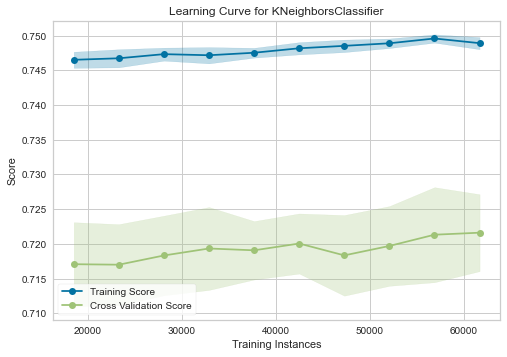

In [39]:
# Learning curve for KNN classifier
Learning_curve_plot(best_Estimator_KNN)

With KNN classifier, the training score and the validation score may not converge. KNN classifier might not benefit with more training data. With increasing training data, the validation score standard deviation also increasing which suggests the model will overfit with more data.

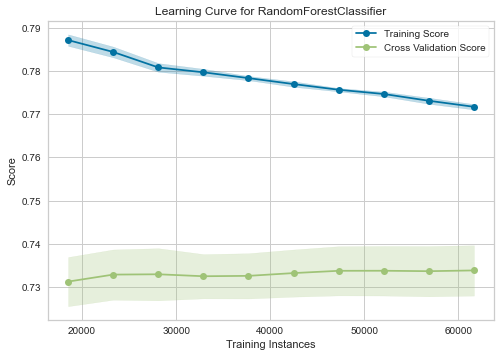

In [40]:
# Learning curve for Random Forest classifier
Learning_curve_plot(best_Estimator_RF)

With Random Forest classifier, the training score and the validation score may converge. With increasing training data, the validation score standard deviation is also not changing which suggests Random forest classifier might benefit with more training data.

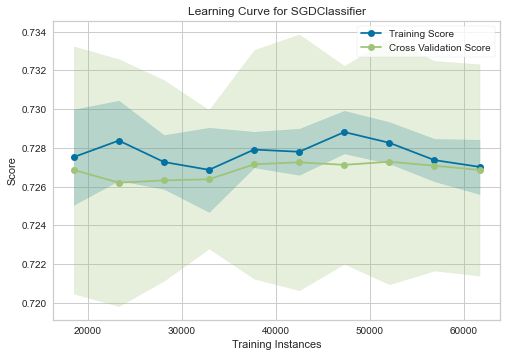

In [41]:
# Learning curve for SVM (SGD) classifier
Learning_curve_plot(best_Estimator_SVM)

With SVM (SGD) classifier, the training score and the validation score converge at low training data. SVM classifier is not learning with more data. The validation score standard deviation very big which suggests the model is overfitting the data.


#### ROC Plot for Classifiers 

The ROC curve shows the relationship between the model's ability to correctly vs incorrectly classify a patient has cardio or not. While this wasn't the primary metric we used to tune our models and compare them, we could potentially make adjustments that could shift the ROC curve to have a higher true positive rate at the expense of increasing the false positive rate.

The ROC curve for the random forest model showed a mean area under the curve AUC of 0.85, for SVM (SGD) classifier showed a mean AUC of 0.79 and for KNN classifier showed an AUC of 0.83. From our analyses above we concluded that random forest performed the best when it comes to accuracy and the ROC curve was best for that model as well, but 3 models had a very similar score.

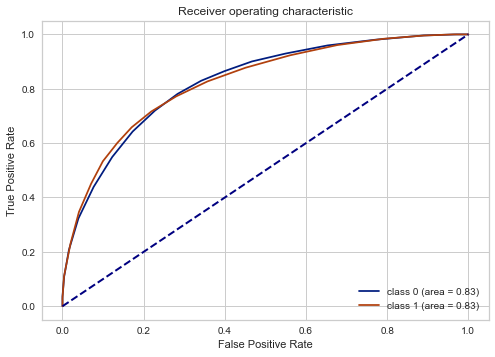

In [42]:
# ROC curve for KNN Classifier
roc_curve_plot(grid_result_KNN, scaled_X, y)

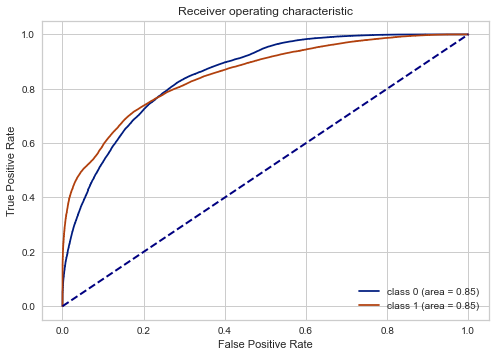

In [43]:
# ROC curve for Random Forest Classifier
roc_curve_plot(grid_result_RF, scaled_X, y)

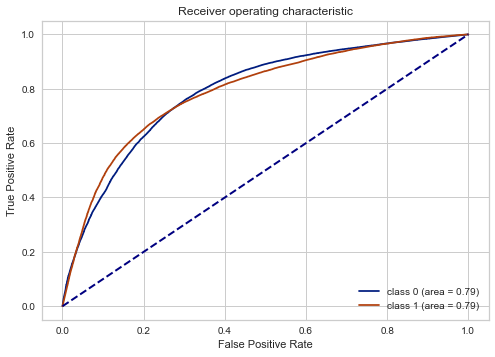

In [44]:
# ROC curve for SVM (SGD) Classifier
roc_curve_plot(grid_result_SVM, scaled_X, y)

#### Predicting *ap_hi* (Systolic Blood Pressure)

The final resulting root mean squared error (RMSE - based on the best avg 10-fold run of the best parameters in a grid search) for each of the regression models (with *ap_lo* excluded as an inappropriate variable) are shown below.

|Model   |RMSE   |
|:---------|:--------------|
| MLR - limited variables| 0.873 |
| MLR - same variable list as RF | 0.870 |
| Random Forest | 0.868 |
| SVR | 0.884 |

The random forest model had the best RMSE of the three tested. As the results are so close, a statistical comparison of the difference between the MLR and Random forest models is necessary as the MLR model has some advantage that could make it the better for practical use if there is no significant improvement from using Random forest. The comparisons are explored in the *Modeling and Evaluation 5* section.

We can also look at learning curves for a couple of the regression models to see how training sizes affect the models. Since the SVR model did not improve on the RF or MLR model, we will only look at the curves for those two.

In [21]:
from yellowbrick.model_selection import LearningCurve

def Learning_curve_plot2(model):
    # Create the learning curve visualizer
    sizes = np.linspace(0.3, 1.0, 10)
    
    visualizer2 = LearningCurve(
    model, cv=rcv, scoring='neg_root_mean_squared_error', train_sizes=sizes, n_jobs=-1)

    visualizer2.fit(X_r3, Y_r)        # Fit the data to the visualizer
    visualizer2.show()           # Finalize and render the figure

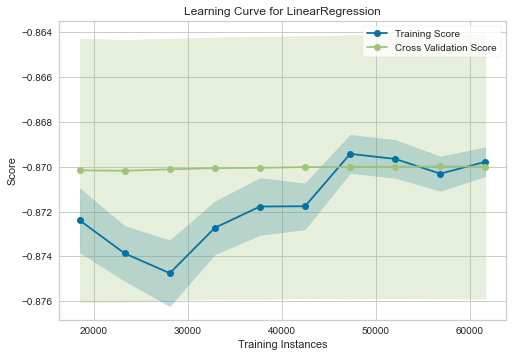

In [23]:
# Learning curve for Multiple Linear Regression
Learning_curve_plot2(mlr3)

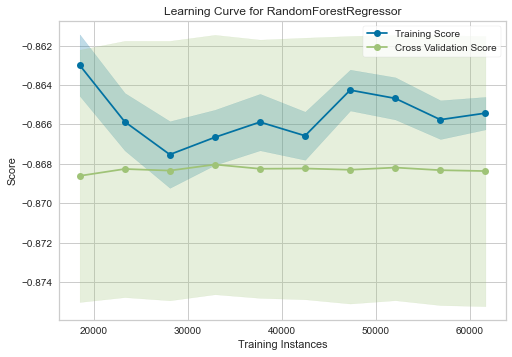

In [24]:
# Learning curve for Random Forest Regression
Learning_curve_plot2(grid_result_rfr2.best_estimator_)

For both linear and Random Forest Regression, the cross validation score, for all practical purposes, did not seem to increase or decrease much for larger sample sizes.

### Modeling and Evaluation 5

#### *Advantages of Each Model*

#### Classifying *cardio* (Cardiovascular Disease Diagnosis)

#### KNN Classifier

Advantages
 - The algorithm is simple and easy to implement.
 - There’s no need to build a model, tune several parameters, or make additional assumptions.
 - The algorithm is versatile. It can be used for classification, regression, and search (as we will see in the next section).

Disadvantages
 - The algorithm gets significantly slower as the number of examples and/or predictors/independent variables increase.
 
For Classifying *cardio*:
 - As discussed previously, a model with a higher recall could be more useful if we were not concerned with false postive diagnoses, and the KNN classifier appears to lean toward the highest recall without any adjustment to the model to specifically favor this measure. If accuracy is of the utmost importance, this would not be best model to use in this case.

#### Random Forest Classifier

Advantages:

 - It is one of the most accurate learning algorithms available. For many data sets, it produces a highly accurate classifier.
 - It runs efficiently on large databases.
 - It can handle thousands of input variables without variable deletion.
 - It gives estimates of what variables that are important in the classification.
 - It generates an internal unbiased estimate of the generalization error as the forest building progresses.
 - It has an effective method for estimating missing data and maintains accuracy when a large proportion of the data are missing.
 
Disadvantages:
 - Random forests have been observed to overfit for some datasets with noisy classification/regression tasks.
 - For data including categorical variables with different number of levels, random forests are biased in favor of those  - attributes with more levels. Therefore, the variable importance scores from random forest are not reliable for this type of data.
 
For Classifying *cardio*:
 - If accuracy and precision are paramount to the classification of *cardio*, the Random Forest model is the best to use based on our results. It also had the highest AUC on the ROC curve. Based on the learning curve this model also appears to have the best chance of getting some improvement to accuracy without too much overfitting if more training data becomes available. Since these models performed so closely, this could be a significant benefit that draws a bit more usefulness in the future for this model than the others.

#### SVM (SGD) Classifier

Advantages:
 - SVM works relatively well when there is a clear margin of separation between classes.
 - SVM is more effective in high dimensional spaces.
 - SVM is effective in cases where the number of dimensions is greater than the number of samples.
 - SVM is relatively memory efficient

Disadvantages:
 - SVM algorithm is not suitable for large data sets.
 - SVM does not perform very well when the data set has more noise i.e. target classes are overlapping.
 - In cases where the number of features for each data point exceeds the number of training data samples, the SVM will underperform.
 - As the support vector classifier works by putting data points, above and below the classifying hyperplane there is no probabilistic explanation for the classification.
 
For Classifying *cardio*:
 - The performance of the SVM model was somewhere in between the Random Forest and KNN models in accuracy and recall. The likely scenarios for which we believe classfying *cardio* will be most useful are either in maximizing accuracy or maximizing recall, so there may not be a relevant purpose for a model that does neither compared to the others.

#### Statistical Comparisons of Classification Models

The models all appear to have very similar performance, so there is good reason to see if there is any significance to treating them differently at all. In order to test for statistically significant differences in performance, we compare the 95% confidence intervals of the accuracy metric of each model type.

In [45]:
from sklearn.model_selection import cross_val_score

acc_KNN = cross_val_score(best_Estimator_KNN, scaled_X, y=y, cv=cv)
acc_RF = cross_val_score(best_Estimator_RF, scaled_X, y=y, cv=cv)
acc_SVM = cross_val_score(best_Estimator_SVM, scaled_X, y=y, cv=cv)

In [46]:
t = 2.26 / np.sqrt(10)

e_SVM_KNN = (1-acc_SVM)-(1-acc_KNN)
e_SVM_RF = (1-acc_SVM)-(1-acc_RF)
e_KNN_RF = (1-acc_KNN)-(1-acc_RF)

stdtot_S_K = np.std(e_SVM_KNN)
stdtot_S_R = np.std(e_SVM_RF)
stdtot_K_R = np.std(e_KNN_RF)

dbarSK = np.mean(e_SVM_KNN)
dbarSR = np.mean(e_SVM_RF)
dbarKR = np.mean(e_KNN_RF)

print ('Range of SVM_KNN confidence interval : [%0.6f,  %0.6f]' % (dbarSK-t*stdtot_S_K,dbarSK+t*stdtot_S_K))
print ('Range of SVM_RF confidence interval  : [%0.6f,  %0.6f]' % (dbarSR-t*stdtot_S_R,dbarSR+t*stdtot_S_R))
print ('Range of KNN_RF confidence interval  : [%0.6f,  %0.6f]' % (dbarKR-t*stdtot_K_R,dbarKR+t*stdtot_K_R))


Range of SVM_KNN confidence interval : [-0.008767,  -0.003842]
Range of SVM_RF confidence interval  : [0.003683,  0.009101]
Range of KNN_RF confidence interval  : [0.010663,  0.014730]


According to above confidence interval range for each two models comparison, none of them contain contain 0. So, we are 95% confident that KNN classifier, Random forest classifier and SVM (SGD) classifier models  are not the same. With 10 fold cross validation, one of the assumptions of independent observations for the t-test is violated, lets validate the statistical significance of the models with 5 X 2 cross validation.

#### 5x2cv paired t-test

The 5x2cv paired t test is a procedure for comparing the performance of two models (classifiers or regressors) by differences in error rate that was proposed by Dietterich to address shortcomings in other methods such as the resampled paired t test and the k-fold cross-validated paired t test.

#### 5X2, paired t-test between KNN classifier and Random Forest classifier Models 

In [47]:
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=best_Estimator_KNN,
                          estimator2=best_Estimator_RF,
                          X=scaled_X, y=y,
                          random_seed=1234)

In [48]:
print('T value:',t, 'P-value', p)

T value: -6.767458351821843 P-value 0.0010705044136934884


 - With a P-value of 0.001 and a T value of -6.76, we reject the null hypothesis (null hypothesis that the learning algorithms have the same error rate on a given dataset). We can conclude that there is a statistically significant difference in error rate between KNN classifier and Random Forest classifier.

#### 5X2, paired t-test between KNN classifier and SVM (SGD) classifier Models 

In [49]:
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=best_Estimator_KNN,
                          estimator2=best_Estimator_SVM,
                          X=scaled_X, y=y,
                          random_seed=1234)

In [50]:
print('T value:',t, 'P-value', p)

T value: -2.2121315637164476 P-value 0.07789529262494929


 - With a P-value of 0.077 and a T value of -2.212, we fail to reject null hypothesis (null hypothesis that the learning algorithms have the same error rate on a given dataset). We can conclude that there is not a significant difference between the error rates of the KNN classifier and SVM (SGD) classifiers at 95% confidence, and this is important to note as it a different result than the first comparison of confidence intervals. This may be another indication of the superiority of the Random Forest model in a maximal accuracy situation if it is shown to be significantly different from SVM.

#### 5X2, paired t-test between Random Forest classifier and SVM (SGD) classifier Models 

In [51]:
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=best_Estimator_RF,
                          estimator2=best_Estimator_SVM,
                          X=scaled_X, y=y,
                          random_seed=1234)

In [52]:
print('T value:',t, 'P-value', p)

T value: 7.253558054183993 P-value 0.0007779296325653931


With a P-value of 0.0007 and a T value of 7.253, we reject null hypothesis (null hypothesis that the learning algorithms have the same error rate on a given dataset). We can conclude that there is a statistically significant difference in error rate between SVM (SGD) classifier and Random Forest classifier, and that we have good reason to suggest that the Random Forest Model is the best to use when accuracy is the most important metric.

#### Predicting *ap_hi* (Systolic Blood Pressure)

The advantages and disadvantages of the random forest and support vector regression models tested are very similar to their counterpart model types in the classification scenario. The linear model, however has an advantage in the model run time. We didn't run the other regression models again separately with their best parameters (as determined by the grid searches - the linear model did not have a grid search) but based on the long times required to run the grid searches, we know that there is no way they can be as fast as the near-instantaneous MLR runs. The MLR model also has the advantage of being able to more clearly interpret the effects of each of the variables in the model if that was of import to the user.

For predicting systolic blood pressure (while ommiting diastolic pressure as it makes little practical sense to include it), there was little visible advantage to using more complicated and/or computationally intensive models than linear methods for prediction. The RMSE only improved slightly with the Random Forest Regression model and the addition of less important features. This could be because the most important feature by far was a binary categorical attribute - *cardio*, and categorical features are not going to be very deterministic of a contiuous variable.

We will test the difference between the Random Forest and the linear model for statistical significance with the same 5x2 paried t-test method.

In [56]:
mlr3

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
grid_result_rfr2.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [58]:
from mlxtend.evaluate import paired_ttest_5x2cv
t, p = paired_ttest_5x2cv(estimator1=mlr3,
                          estimator2=grid_result_rfr2.best_estimator_,
                          X=X_r3, y=Y_r,
                          random_seed=1234)

In [59]:
print('T value:',t, 'P-value', p)

T value: -4.67045075506956 P-value 0.0054803614561008416


Based on the T and p values above, we can conclude with 95% confidence that there is evidence of a significant difference between the RMSE of the Random Forest regression and MLR models. With this information we would say that the Random Forest model has significant benefit in predicitve capability but with the consideration that it will take more time to run.

### Modeling and Evaluation 6

#### *Important Attributes*

#### Classifying *cardio* (Cardiovascular Disease Diagnosis) with Random Forest Classifier

We can view the most important features in the top performing Random  forest classifier by viewing the coefficents for the weights of each variable in predicting *cardio*. Feature importance below was performed for the model created using the model with hyperparameters tuned by the grid search.

In [60]:
# Important features with their weights 
features = df_onehot.columns

imp_feature_df = pd.DataFrame({'feature_names':df_onehot.columns, 
                               'Coef_weights':Coef_weights_RF})
imp_feature_df.sort_values(by='Coef_weights', inplace=True, ascending=False )

imp_feature_df

,feature_names,Coef_weights
2,ap_hi,0.393627
3,ap_lo,0.170816
7,age_years,0.133148
11,cholesterol_3,0.066210
1,weight,0.062721
8,BMI,0.062106
0,height,0.053917
10,cholesterol_2,0.012117
6,active,0.010959
13,gluc_3,0.008982


Text(0, 0.5, 'Feature Names')

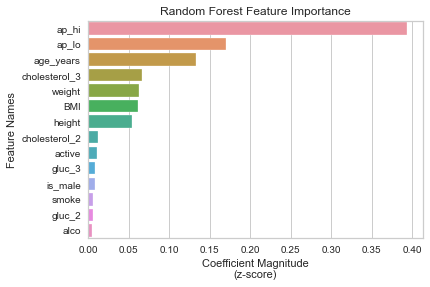

In [61]:
# Visulization of important features 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ax = sns.barplot(x ='Coef_weights', y = 'feature_names',data=imp_feature_df, orient= 'h')
ax.set_title("Random Forest Feature Importance")
ax.set_xlabel("Coefficient Magnitude\n(z-score)")
ax.set_ylabel("Feature Names")

 - Random Forest feature importance display shows the top 5 most important features. For random forest, the top 5 features are ap_hi, ap_lo, age_years, Cholesterol_3 and weight. *ap_hi* has three times the coefficient magnitude by z-score as the next non-blood pressure realted variable (age). 


 - The high positive influence of systolic blood pressure on positive diagnosis is consistent with what we found in visualizing this data in *Lab 1*, and the top weight demonstrates that this is by far the most important variable in the prediction. All of the variables that appeared as positive influences on a positive diagnosis are amoung the common contributors to heart disease outlined by the American Heart Association, so we don't see anything unexpected here. It is still interesting that many of the commonly held beliefs about certain behaviors like smoking, alcohol, and activity had almost no effect on classfication based on this data.

#### Feature Importance using Recursive Feature Elimination - classifying *cardio* (Cardiovascular Disease Diagnosis)

In addition to looking at the model parameters directly, we can use recursive feature elimination to identify which attributes are not relevant to the model.

In [62]:
# recursive Feature elimination to identify important features
from sklearn.feature_selection import RFECV

# Instance of Recursive Feature Elimination
rfecv = RFECV(estimator=best_Estimator_RF, step=1, cv=cv, n_jobs=-1, scoring='accuracy')

# Fit RFE
rfecv.fit(scaled_X, y)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=1234, shuffle=True),
      estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                       class_weight=None, criterion='gini',
                                       max_depth=15, max_features='auto',
                                       max_leaf_nodes=None, max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=4, min_samples_split=10,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
                                       oob_score=False, random_state=1234,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=-1, scoring='accuracy', step=1,
      verbose=0)

In [63]:
# get column names
columns = pd.DataFrame(list(df_onehot.columns))

# Get the ranking of features
ranking = pd.DataFrame(rfecv.ranking_)

# ranking and their importance
rfe_selected = pd.DataFrame()
rfe_selected  = pd.concat([columns, ranking], axis=1)
rfe_selected.columns = ['Feature Name', 'Ranking']
rfe_selected_sorted = rfe_selected.sort_values(by=['Ranking'], ascending=True)
print(rfe_selected_sorted)

     Feature Name  Ranking
0          height        1
1          weight        1
2           ap_hi        1
3           ap_lo        1
4           smoke        1
6          active        1
7       age_years        1
8             BMI        1
9         is_male        1
10  cholesterol_2        1
11  cholesterol_3        1
12         gluc_2        1
13         gluc_3        1
5            alco        2


Recursive feature elimination suggested to include all features except "alcohol" feature. This echoes the feature importance by z-score of the Random Forest model which shows *alco* as that of lowest importance. This is an interesting discovery as alcohol is often mentioned by many as a contributor to heart disease, yet it shows no effects here. It is possible that there is a collection bias as discussed in Lab 1, or perhaps the measure that represents a '1' in the binary response is not a "severe" enough drinking habit.

#### Important Features - Predicting *ap_hi* (Systolic Blood Pressure): Random Forest Regression

In [87]:
#running RF with best parameters
rfr_f = RandomForestRegressor(max_depth=5, n_estimators=1000)
rfr_f.fit(X_r3, Y_r)
#rfr_f_scores = cross_val_score(rfr_f, X_r3, Y_r, scoring='neg_root_mean_squared_error', cv=cv)
#rfr_f_preds = cross_val_predict(rfr_f, X_r3, Y_r, cv=rcv)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

Random Forest Regression with sklearn has a feature importance function that returns the feature importances of each included variable.

In [90]:
rfr_imp = rfr_f.feature_importances_
rfr_imp_df = pd.DataFrame({'Feature Importance': rfr_imp}, index=X_r3o.columns)
rfr_imp_df

,Feature Importance
cardio,0.748224
weight,0.089862
BMI,0.065733
age_years,0.051050
cholesterol_3,0.024555
cholesterol_2,0.014703
gluc_2,0.001215
gluc_3,0.000327
smoke,0.001877
alco,0.001016


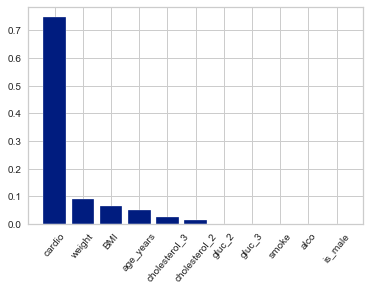

In [92]:
# plot feature importance
from matplotlib import pyplot
pyplot.bar(X_r3o.columns, rfr_imp)
pyplot.xticks(rotation=50)
pyplot.show()

Interestingly, the binary feature *cardio* that is our target class in the classification models is by far the highest predictor in the Random forest regression model. It is not surprising as the *ap_hi* feature is the most influential for classifying *cardio* and the reverse would make sense to be true, but it is unfortunate as we can't get much preditive power for a continuous class out of a binary predictor.

#### Important Features - Predicting *ap_hi* (Systolic Blood Pressure): MLR

As mentioned previously, we can determine feature importance for the linear regression model from the variable coefficients because the data is normalized by scaling 0 to 1.

In [65]:
# intercept and regression model coefficients
coef3 = mlr3.coef_[0].tolist()
coefdf3 = pd.DataFrame(X_r3o.columns, columns=['Variable'])
coefdf3['Coefficient'] = coef3

print('Intercept: \n', mlr.intercept_)
coefdf3

Intercept: 
 [2.23788845e-16]


,Variable,Coefficient
0,cardio,0.350885
1,weight,0.141478
2,BMI,0.047486
3,age_years,0.112352
4,cholesterol_3,0.070732
5,cholesterol_2,0.056450
6,gluc_2,0.019542
7,gluc_3,-0.010659
8,smoke,0.000890
9,alco,0.020005


To no surprise, our classification task target *cardio* is the most important variable in the linear analysis, and being binary, this is a good indication that there aren't any exceptionally good continous variables in our data that can predict *ap_hi*. Weight had the next highest coefficient, which is intuitive again based on our understanding of high blood pressure and heart disease from the AHA. There also did not appear to be any attributes with large negative effects.

## Deployment

The data we have is being used to predict cardiovascular disease using a few easily obtained variables so it is geared for use both by medical professionals and perhaps for people to use on their own without visiting a doctor first (could be used at home with a few basic tests or in easily deployed accessible places like drug stores etc).

Clearly, an accurate model for predicting disease early can save lives if it means effective treatments and/or interventions can be deployed sooner. The utility of a reliable model is in a form of risk identification. If our model flags a patient as being at risk, despite having no expressed symptoms, a clinician may use it to begin a more focused analysis on the patient. Thus, this is a tool most suited for prescreening, and since this model would most likely be an early warning tool, a higher rate of false positives is acceptable. The real value in the model would be measured by how many patients could be identified early and possibly by how much time could be saved for doctors and patients alike by identifying patients that need attention outside of a doctor's office.

Additional collected data could potentially make the model more accurate but some of the advantage of a pre-screening model lies in the speed and ease of collecting a few key pieces of information so additional data would only be usedful if it had more significant impact on classification than the top few we identified in this dataset. Some additional variables that were listed in *Lab1* like Stress level, Familiy History, and waist circumference might be worth testing in this regard.

Frequent updates to the model would not be necessary as the variables examined shouldn't be expected to change much over time. Updates would mostly be warranted just in the interest of gathering more information (like additional variables and additional observations) and making tweaks to the specific model parameters.

The regression analysis for predicting ap_hi did not perform very well or show much particular practical worth. Since the top variable contributing to high blood pressure was a positive heart disease diagnosis, there isn't much value to using a model that is predicting blood pressure, a metric that is highly attributable to cardiovascular disease, primarily through the lens of whether someone is already diagnosed with a problem that is generally treated in a similar manner.

## Exceptional Work

We used grid searches to tune the hyperparameters for all of our classification models; these are shown in the "Creation of 3 Different Models" Section. We can also examine each parameter's performance used in grid search with visualization and identify which are the most significant parameters in predicting *cardio*. We chose validation curves to visualize each parameter's performance in the classification models.

#### Validation Curves

A Validation Curve is an important diagnostic tool that shows the sensitivity between to changes in a  model's accuracy with change in some parameter of the model. A validation curve is typically drawn between some parameter of the model and the model's score.

Validation Curve is also helpful in identifying the influence of a single hyperparameter on the training score and the validation score to find out whether the estimator is overfitting or underfitting for some hyperparameter values

#### KNN Classifier parameter Visualizations

<u> n_neighbors parameter</u>

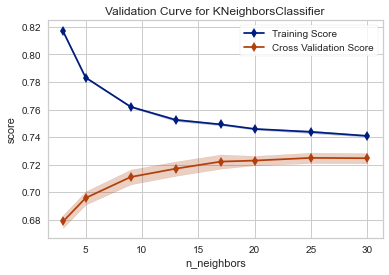

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='n_neighbors', ylabel='score'>

In [67]:
from yellowbrick.model_selection import ValidationCurve
viz = ValidationCurve(
    KNN, param_name="n_neighbors",
    param_range=[3,5,9, 13, 17, 20, 25, 30], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training score converge to a value that is quite low with increasing K value (number of neighbors). So KNN classfier can be generalized with intermediate value of K.

<u>leaf_size parameter</u>

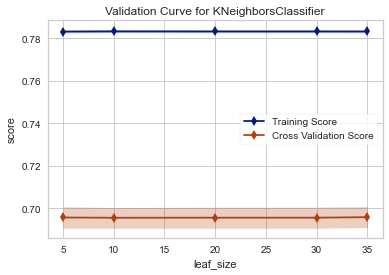

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='leaf_size', ylabel='score'>

In [68]:
viz = ValidationCurve(
    KNN, param_name="leaf_size",
    param_range=[5, 10, 20, 30, 35], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

No change in validation score and the training score with increasing leaf_size parameter. Leaf_size parameter may not be useful parameter in predicting cardio in KNN classifier.

<u>algorithm parameter</u>

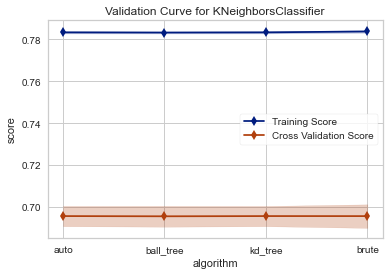

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='algorithm', ylabel='score'>

In [69]:
viz = ValidationCurve(
    KNN, param_name="algorithm",
    param_range=['auto', 'ball_tree', 'kd_tree', 'brute'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

There is no change in the validation score and the training score for various Algorithms (which is used to compute the nearest neighbors). Algotithm parameter may not be useful parameter in predicting cardio in KNN classifier.

<u>metric parameter</U>

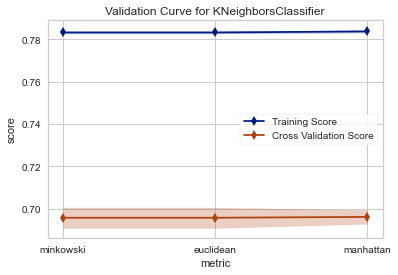

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='metric', ylabel='score'>

In [70]:
viz = ValidationCurve(
    KNN, param_name="metric",
    param_range=['minkowski','euclidean', 'manhattan'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

There is no change in the validation score and the training score for various values of metric parameter. Metric parameter may not be useful parameter in predicting cardio in KNN classifier.

<u>weights parameter</u>

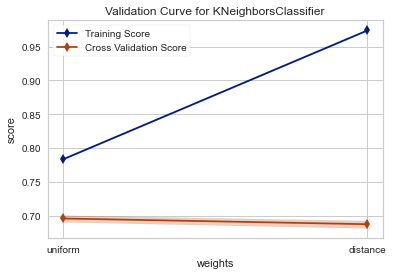

<AxesSubplot:title={'center':'Validation Curve for KNeighborsClassifier'}, xlabel='weights', ylabel='score'>

In [71]:
viz = ValidationCurve(
    KNN, param_name="weights",
    param_range=['uniform','distance'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

The validation score and the training score is ok with "uniform" weight parameter, but there is big difference between validation score and training score with "distance" weight parameter, which is overfit condition. We need to go with "uniform" weight parameter in predicting the cardio.

<b>n_neighbors and weights parameters are most significant parameters in predicting cardio with KNN classifier</b>

#### Random Forest Classifier parameter Visualizations

<u>n_estimators parameter</u>

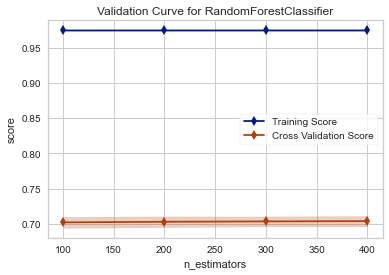

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='n_estimators', ylabel='score'>

In [72]:
viz = ValidationCurve(
    RF, param_name="n_estimators",
    param_range=[100, 200, 300, 400], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

There is no change in the validation score and the training score as number of trees increased in the forest parameter. n_estimators parameter may not be useful parameter in predicting cardio in random forest classifier.

<u>max_depth parameter</u>

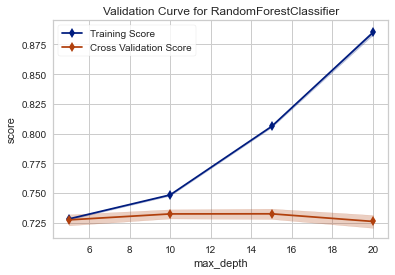

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='max_depth', ylabel='score'>

In [73]:
viz = ValidationCurve(
    RF, param_name="max_depth",
    param_range=[5, 10, 15, 20], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

The validation score and the training score is ok with low values of max_depth parameter, but there is huge difference between validation score and training score with increasing values of max_depth parameter, which is overfit condition. We need to go with lower values of max-depth parameter for best model in predicting the cardio.

<u>min_samples_leaf parameter</u>

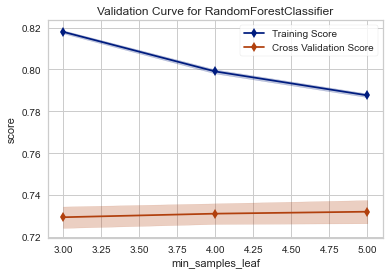

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='min_samples_leaf', ylabel='score'>

In [74]:
viz = ValidationCurve(
    RF, param_name="min_samples_leaf",
    param_range=[3, 4, 5], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training score converge to a value that is quite low accuracy with increasing min_samples_leaf (The minimum number of samples required to be at a leaf node). So Random Forest classfier can be generalized with intermediate value of min_samples_leaf parameter.

<u>min_samples_split parameter</u>

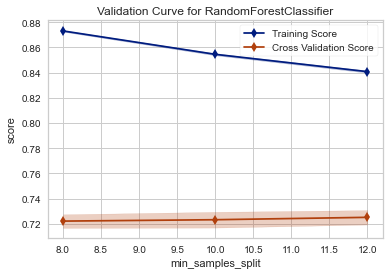

<AxesSubplot:title={'center':'Validation Curve for RandomForestClassifier'}, xlabel='min_samples_split', ylabel='score'>

In [75]:
viz = ValidationCurve(
    RF, param_name="min_samples_split",
    param_range=[8, 10, 12], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training score converge to a value that is quite low accuracy with increasing min_samples_split (The minimum number of samples required to split an internal node). So Random forest classfier can be generalized with intermediate value of min_samples_leaf parameter.

<b>max_depth, min_samples_leaf and min_samples_split parameters are most significant parameters in predicting cardio with Random Forest classifier</b>

#### SVM Classifier parameter Visualizations

<u>loss parameter</u>

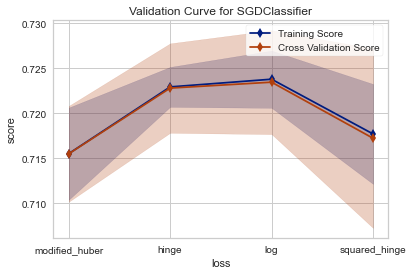

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='loss', ylabel='score'>

In [76]:
viz = ValidationCurve(
    SVM, param_name="loss",
    param_range=['modified_huber', 'hinge', 'log', 'squared_hinge'], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training scores are increasing with 'modified_huber', 'hinge' and 'log' values for loss parameter and decreasing the scores with 'squared_hinge' loss parameter. 'hinge' loss parameter might be most significant in predicting cardio with SVM classifier. 

<u>alpha parameter</u>

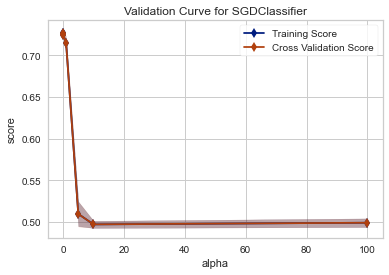

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='alpha', ylabel='score'>

In [77]:
viz = ValidationCurve(
    SVM, param_name="alpha",
    param_range=[0.001, 0.01, 0.1, 1, 5, 10, 100], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training scores are desceasing with increasing values for alpha parameter. Low values of alpha parameter might be most significant in predicting cardio with SVM classifier. 

<u>max_iter parameter</u>

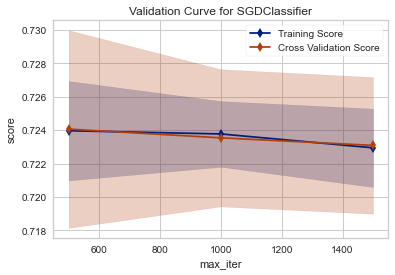

<AxesSubplot:title={'center':'Validation Curve for SGDClassifier'}, xlabel='max_iter', ylabel='score'>

In [78]:
viz = ValidationCurve(
    SVM, param_name="max_iter",
    param_range=[500, 1000, 1500], cv=10, scoring="accuracy"
)

# Fit and show the visualizer
viz.fit(scaled_X, y)
viz.show()

Both the validation score and the training scores are inceasing with increasing values for max_iter parameter upto 1000 and converges at 1000, then validation score is more than training score. Value less than 100 for max_iter parameter might be most significant in predicting cardio with SVM classifier. 

<b> The loss, alpha and max-iter parameters are most significant parameters in predicting cardio with SVM classifier</b>

### Additional Models

Since the classification models we tested had very similar results, we tested a few more to see if there might be one we missed with exceptionally better performance.

#### Classifying *cardio* - Decision Trees

In [79]:
from sklearn.tree import DecisionTreeClassifier

# define parameters
max_depth_DT = [1, 5,10, 15, 20, 25, 30, 32]
min_samples_split_DT = [0.1, 1, 10]
max_features_DT = list(range(1, scaled_X.shape[1]))
random_state_DT = [1234]

# define grid search
param_grid_DT = dict(max_depth=max_depth_DT, min_samples_split=min_samples_split_DT,
                     max_features=max_features_DT, random_state=random_state_DT)

DT = DecisionTreeClassifier()

grid_search_DT = GridSearchCV(estimator=DT, param_grid=param_grid_DT, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [80]:
%%time
grid_result_DT = grid_search_DT.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_DT.best_score_, grid_result_DT.best_params_))
means = grid_result_DT.cv_results_['mean_test_score']
stds = grid_result_DT.cv_results_['std_test_score']
params = grid_result_DT.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 312 candidates, totalling 3120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 1290 tasks      | elapsed:   24.2s
[Parallel(n_jobs=-1)]: Done 1688 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 2588 tasks      | elapsed:  1.0min


Best: 0.730222 using {'max_depth': 5, 'max_features': 13, 'min_samples_split': 10, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 0.1, 'random_state': 1234}
0.000000 (0.000000) with: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 1, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 1, 'min_samples_split': 10, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 2, 'min_samples_split': 0.1, 'random_state': 1234}
0.000000 (0.000000) with: {'max_depth': 1, 'max_features': 2, 'min_samples_split': 1, 'random_state': 1234}
0.518074 (0.004874) with: {'max_depth': 1, 'max_features': 2, 'min_samples_split': 10, 'random_state': 1234}
0.573311 (0.006126) with: {'max_depth': 1, 'max_features': 3, 'min_samples_split': 0.1, 'random_state': 1234}
0.000000 (0.000000) with: {'max_depth': 1, 'max_features': 3, 'min_samples_split': 1, 'random_state': 1234}
0.573311 (0.006126) wit

[Parallel(n_jobs=-1)]: Done 3120 out of 3120 | elapsed:  1.4min finished


In [81]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_DT =grid_result_DT.best_estimator_
best_Estimator_DT

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=13, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')

In [82]:
# Display model metrics
displayModel_metrics(best_Estimator_DT, grid_result_DT, scaled_X, y, cv)

Fold Scores:
 
[0.73019116 0.73121261 0.72989931 0.73861646 0.72081144 0.72548161
 0.73277875 0.7267951  0.72942207 0.73701109]
 
Best Accuracy   :  0.730
Mean Accuracy   :  0.7302219599667404
Mean Precision  :  0.7475747363382776
Mean Recall     :  0.6865781710914454
Mean Fit Time   :  0.34920463562011717
Mean Score Time :  0.01717231273651123
CV Time         :  0.6671109199523926


With Decision tree classifier achieving an accuracy of 73% which is better than KNN classifier and SVM classifier. But the accuracy is less than Random forest classifier

#### Classifying *cardio* -  Naive Bayes

In [83]:
from sklearn.naive_bayes import GaussianNB

var_smoothing_GNB = [1e-15, 1e-09, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1, 10, 100]

# define grid search
param_grid_GNB = dict(var_smoothing=var_smoothing_GNB)

GNB = GaussianNB()

grid_search_GNB = GridSearchCV(estimator=GNB, param_grid=param_grid_GNB, n_jobs=-1, cv=cv, 
                               scoring='accuracy',error_score=0, verbose=1)

In [84]:
%%time
grid_result_GNB = grid_search_GNB.fit(scaled_X, y)
# summarize results
print("Best: %f using %s" % (grid_result_GNB.best_score_, grid_result_GNB.best_params_))
means = grid_result_GNB.cv_results_['mean_test_score']
stds = grid_result_GNB.cv_results_['std_test_score']
params = grid_result_GNB.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.1s


Best: 0.692599 using {'var_smoothing': 1e-15}
0.692599 (0.006505) with: {'var_smoothing': 1e-15}
0.692599 (0.006505) with: {'var_smoothing': 1e-09}
0.692599 (0.006505) with: {'var_smoothing': 1e-08}
0.692599 (0.006505) with: {'var_smoothing': 1e-07}
0.692599 (0.006505) with: {'var_smoothing': 1e-06}
0.692599 (0.006505) with: {'var_smoothing': 1e-05}
0.692599 (0.006505) with: {'var_smoothing': 0.0001}
0.679421 (0.006248) with: {'var_smoothing': 1}
0.638968 (0.005157) with: {'var_smoothing': 10}
0.537425 (0.002384) with: {'var_smoothing': 100}
Wall time: 2.04 s


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


In [85]:
# The GridSearch algorithm determined the following optimal parameters
best_Estimator_GNB =grid_result_GNB.best_estimator_
best_Estimator_GNB

GaussianNB(priors=None, var_smoothing=1e-15)

In [86]:
# Display model metrics
displayModel_metrics(best_Estimator_GNB, grid_result_GNB, scaled_X, y, cv)

Fold Scores:
 
[0.69867211 0.69239749 0.69677513 0.69658494 0.6770286  0.68797431
 0.69483363 0.68666083 0.69775248 0.69731465]
 
Best Accuracy   :  0.693
Mean Accuracy   :  0.6925994184947528
Mean Precision  :  0.7390342595338927
Mean Recall     :  0.5853982300884957
Mean Fit Time   :  0.12156500816345214
Mean Score Time :  0.018935632705688477
CV Time         :  0.3123345375061035


With GaussianNB classifier achieving an accuracy of 69.2% which is least among all classifier models we tested.

#### Predict *ap_hi* (Systolic Blood Pressure): Ridge Regression

Another regression model we can attempt is Ridge regression. Ridge regression is a technique often used when multicollinearity is an issue or when the number of attributes exceeds the number of observations (not an issue we have). Ridge Regression adds a degree of bias to the regression estimates to reduce the standard error.

In [29]:
%%time

from sklearn.linear_model import Ridge

#Ridge regression
ridgemodel=Ridge()

# define models and parameters
alpha = [.1, 1, 10] 

# define grid search
grid4 = dict(alpha=alpha)
grid_search4 = GridSearchCV(estimator=ridgemodel, param_grid=grid4, n_jobs=-1, cv=rcv, scoring='neg_root_mean_squared_error')

grid_result_ridgemodel = grid_search4.fit(X_r3, Y_r)
# summarize results
print("Best: %f using %s" % (grid_result_ridgemodel.best_score_, grid_result_ridgemodel.best_params_))
means4 = grid_result_ridgemodel.cv_results_['mean_test_score']
stds4 = grid_result_ridgemodel.cv_results_['std_test_score']
params4 = grid_result_ridgemodel.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.869988 using {'alpha': 10}
-0.869988 (0.005895) with: {'alpha': 0.1}
-0.869988 (0.005895) with: {'alpha': 1}
-0.869988 (0.005894) with: {'alpha': 10}
Wall time: 317 ms


Ridge regression didn't show any improvement to the RMSE of the model. This likely because of the low number of attributes and high observations without too much multicollinearity.

### References

 - https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb


 - https://www.scikit-yb.org/en/latest/api/model_selection/learning_curve.html


 - https://scikit-learn.org/stable/modules/learning_curve.html
